# Autoencoder
### Utilizing tabular data
- Train an autoencoder to compress 4 features down to 2 datapoints that vary from 0 to 1 (output of sigmoid function), then attempts to reconstruct the original data
- Generate new data points using the decoder layer of the model by inputting latent variables sampled from a uniform distribution

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
n_examples = 10000
f1 = np.random.normal(0,1, size=(n_examples, 1))
f2 = np.random.normal(0,3, size=(n_examples, 1))
f3 = np.random.normal(-3,2, size=(n_examples, 1))
f4 = np.random.normal(5,1, size=(n_examples, 1))
data = np.concatenate([f1,f2,f3,f4], axis=1)
# add one additional row that has an anomalous value for feature 1
anomalous_datapoint = np.asarray([-20, 2, -4, 10]).reshape(1, -1)
data = np.concatenate([data, anomalous_datapoint], axis=0)
data.shape

# train model on first 9500 data points
X_train = data[:9500]
X_test = data[9500:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Define Model
model = Sequential()
model.add(Dense(2, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dense(4, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [4]:
history = model.fit(X_train, X_train, epochs=64, batch_size=32, verbose=0, validation_split=0.1)

### Check model fit

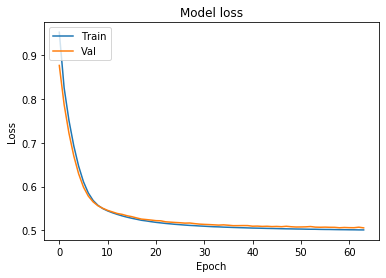

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [6]:
X_pred = model.predict(X_test)
print(mean_squared_error(X_test, X_pred))

0.6752222589625232


### Plot residuals for feature 1

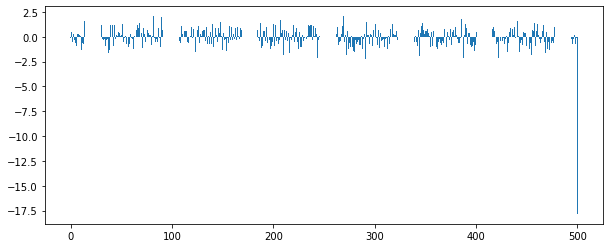

In [7]:
plt.figure(figsize=(10,4))
plt.bar(range(X_test.shape[0]), (X_test[:, 0] - X_pred[:, 0]))
plt.show()

### MSE on test set for feature 1 (excluding anomalous example)

In [8]:
mean_squared_error(X_test[:-1, 0], X_pred[:-1, 0])

0.618310982603348

### SE for feature 1 on anomalous example
- anomalous data point would have been easily identifed

In [9]:
mean_squared_error(X_test[-1:, 0], X_pred[-1:, 0])

318.276720887168

# Generate new data using the trained decoder
### First, retrieve decoder from the trained model

In [10]:
decoder_input = Input(shape=(2,))
decoder_output = model.layers[1](decoder_input)
decoder_model = Model(decoder_input, decoder_output)

### Generate one new datapoint, given a vector with 2 elements

In [11]:
scaler.inverse_transform(decoder_model.predict(np.asarray([0.5, 0.5]).reshape(-1,2)))

array([[-0.02718519,  0.3345472 , -2.9523158 ,  4.990638  ]],
      dtype=float32)

### Plot the distribution of activation values during testing to see what kind of a distribution they appear to be

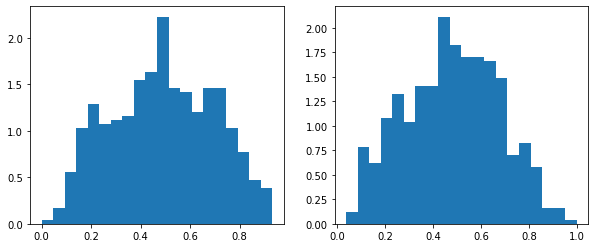

In [12]:
get_activations = K.function([model.input], [model.layers[0].output])
activations = get_activations([X_test])[0]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(activations[:, 0], bins=20, density=True)
ax[1].hist(activations[:, 1], bins=20, density=True)
plt.show()

##### Looks like a beta distribution shifted/scaled (linearly transformed)

In [13]:
print('Distribution skews')
print(skew(activations[:, 0]))
print(skew(activations[:, 1]))
print('\nDistribution kurtosis')
print(kurtosis(activations[:, 0]))
print(kurtosis(activations[:, 1]))

Distribution skews
-0.010756253264844418
-0.023468947038054466

Distribution kurtosis
-0.8674199667651941
-0.687367320238085


##### From above, the plot and kurtosis values show that these are most likely not normally distributed because their tails are too skinny. Also bounded between 0 and 1

##### Find beta distributions that resemble the distributions of the activation outputs

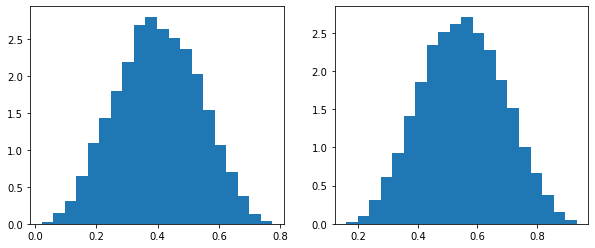

Distribution skews
-0.009719417925695624
0.015621174206832369

Distribution kurtosis
-0.5258423533085277
-0.4912628767073226


In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
beta_vals1 = np.random.beta(4,4, 10000)/(1/0.8)
beta_vals2 = np.random.beta(5,5, 10000)/(1/0.9)+0.1
ax[0].hist(beta_vals1, bins=20, density=True)
ax[1].hist(beta_vals2, bins=20, density=True)
plt.show()

print('Distribution skews')
print(skew(beta_vals1))
print(skew(beta_vals2))
print('\nDistribution kurtosis')
print(kurtosis(beta_vals1))
print(kurtosis(beta_vals2))

### Generate lots of new datapoints by sampling from the two beta distributions

In [15]:
#new_data = decoder_model.predict(np.random.uniform(0,1,size=(5000,2)))
#new_data = decoder_model.predict(np.random.normal(0.5,.25,size=(5000,2)).clip(0,1)).reshape(-1,4)
a1 = np.random.beta(4,4, 10000)/(1/0.8)
a2 = np.random.beta(5,5, 10000)/(1/0.9)+0.1
a = np.concatenate([a1, a2], axis=0).reshape((-1,2))
new_data = decoder_model.predict(a).reshape(-1,4)
new_data = scaler.inverse_transform(new_data)

In [16]:
X_train = scaler.inverse_transform(X_train)
X_test = scaler.inverse_transform(X_test)

### Compare the feature distributions in the training data to the simulated data

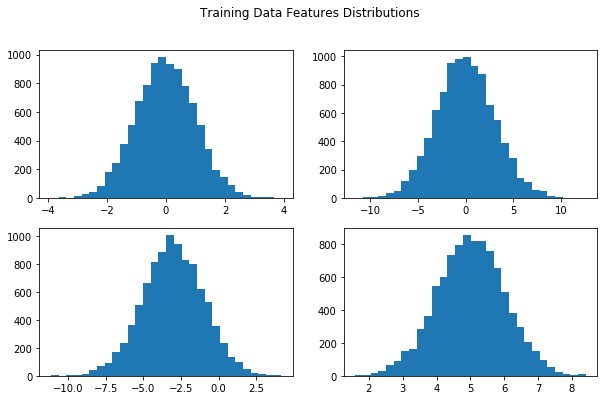

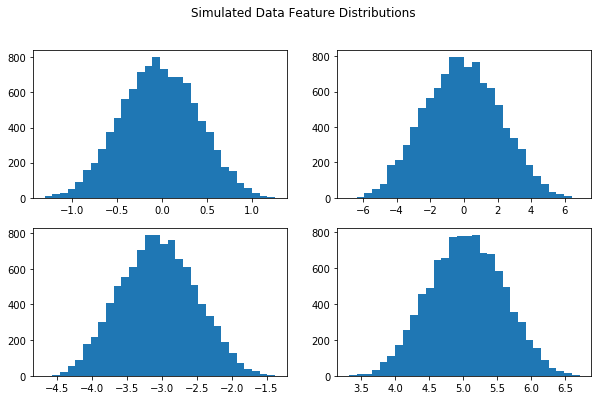

In [17]:
fig, axes = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Training Data Features Distributions')
axes[0,0].hist(X_train[:, 0], bins=30)
axes[0,1].hist(X_train[:, 1], bins=30)
axes[1,0].hist(X_train[:, 2], bins=30)
axes[1,1].hist(X_train[:, 3], bins=30)
plt.show()

fig, axes = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Simulated Data Feature Distributions')
axes[0,0].hist(new_data[:, 0], bins=30)
axes[0,1].hist(new_data[:, 1], bins=30)
axes[1,0].hist(new_data[:, 2], bins=30)
axes[1,1].hist(new_data[:, 3], bins=30)
plt.show()

##### Also note this was a simplified case b/c the decoder here doesn't have any layers with non-linear activation functions